# Libraries and Helper Functions

In [15]:
# Import necessary libraries

# Cleaning
import os
from datetime import datetime
import re
import numpy as np

# Visualization
import pandas as pd
import sweetviz as sv
# from pandasgui import show
from pivottablejs import pivot_ui
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Custom library

import sys
sys.path.append('../libs/dataprep/')
from preprocessing import *
from constants import *
import importlib

# Hypothesis Testing
import scipy.stats as stats

# Read and Load Data

In [2]:
df = load_df(filepath,datatypes)

In [3]:
df.dtypes

datetime                   datetime64[ns]
event_name                         object
user_pseudo_id                     object
page_location                      object
page_referrer                      object
engagement_time_msec              float64
orderId                            object
customerId                         object
Status                             object
loginStatus                        object
sessionStatus                      object
unique_customerId_count           float64
CSS_PATH                           object
ga_session_number                  object
URI                                object
Diner or Sicpama member            object
storeId                            object
engagement_msec_total             float64
CSS_PATH_labeled                   object
dtype: object

In [4]:
df = sort_df(preprocess(df, modify_uri, modify_css))

In [31]:
df.to_csv('preprocessed_ga.csv', index=False)

# Funnel Process Analysis

In [5]:
funnel_df = get_order_process(df)

In [6]:
funnel_df

,Process,Counts
0,menus,5141
1,auth,5125
2,tab,2963
3,payment/approval,2432
4,customer-receipt,1955
5,callback_from_sns,1843
6,food-courts/26cfc3a6-390e-4818-8a64-c5e162413d28,337
7,token,652
8,search,99
9,feedback,85


In [7]:
funnel_proc = ["session_start", "menus", "tab", "payment/approval", "success", "failed"]

funnel_process = funnel_df[funnel_df.Process.isin(funnel_proc)].sort_values(by = "Counts", ascending = False)

In [8]:
funnel_process

,Process,Counts
17,session_start,5172
0,menus,5141
2,tab,2963
3,payment/approval,2432
18,success,217
19,failed,194


<Axes: title={'center': 'Funnel Process'}, xlabel='Process'>

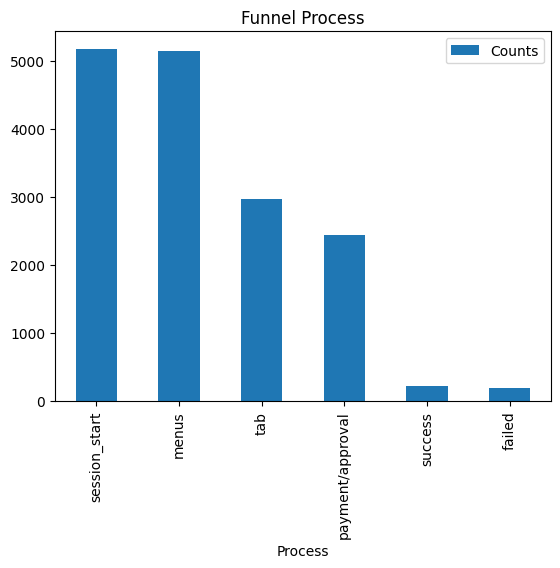

In [9]:
funnel_process.plot(kind="bar", x="Process", y="Counts", title = "Funnel Process")

In [10]:
df.CSS_PATH_labeled.unique()

array([nan, 'diner-auth-login_banner', 'diner-menus-btn_menu_banner',
       'diner-menus-btn_put_menu', 'diner-menus-btn_to_tab',
       'diner-tab-tab_chg_amt', 'diner-pay-its_on_me',
       'diner-tab-undefined', 'diner-pay-pay_mine',
       'diner-tab-btn_to_payments', 'diner-payment-all',
       'diner-menus-btn_category', 'diner-menus-btn_quick_add_menu',
       'diner-tab-btn_to_menus', 'diner-auth-btn_close_login_page',
       'diner-auth-all', 'diner-customer_receipt-all',
       'diner-tab-payment_option_banner', 'diner-pay-spin_wheel',
       'diner-pay-split_evenly', 'diner-auth-bottom_sheet_background',
       'diner-menus-others_in_menu_details',
       'diner-menu-horizontal_scroll_menus', 'diner-tab-close_login_page',
       'diner-auth-btn_kakao_login', 'food-courts',
       'diner-auth-banner_above_login_banner',
       'diner-menus-btn_to_food_court', 'diner-tab-btn_del_menu',
       'diner-menus-top_progess_bar', 'diner-auth-btn_guest_login',
       'diner-menus-btn

# Identify potential bottlenecks in the button transitions

Null Hypothesis : There is average engagement time spent on the transition buttons on failed session is less than or equal to the engagement time spent on success session.

Alternate Hypothesis : The average engagement time spent on failed session is greater than the average engagement time spent on success session

# Hypothesis Test

In [13]:
transits_checker = ["btn_to", "btn-from", "btn_back_from"]


condition = df.CSS_PATH_labeled.str.contains('|'.join(transits_checker), case=False, na=False)
failed = df.sessionStatus == "Failed"
success = df.sessionStatus == "Success"

In [16]:
n = 3000 # take a sample of 3000 and see if the engagement time between the two groups are significant
sample_failed = df[condition & failed].sample(n=n).replace(np.nan, 0)
sample_success = df[condition & success].sample(n=n).replace(np.nan, 0)

In [17]:
t_stat, p_value = stats.ttest_ind(sample_failed.engagement_time_msec,sample_success.engagement_time_msec) 

# Check the significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no sig")

Reject the null hypothesis: There is a significant difference between the groups.


Since there is a significant difference in the engagement time between the two groups, we can plot some graphs to visualize the difference and further investigate where the largest difference is coming from

In [18]:
df.sessionStatus.unique()

array(['Failed', 'Success'], dtype=object)

In [19]:
# Session status statistics
sess_status = df.groupby(["sessionStatus","user_pseudo_id"])\
                .nunique() \
                .reset_index() \
                .sessionStatus \
                .value_counts()

In [20]:
sess_status

sessionStatus
Failed     2697
Success    2616
Name: count, dtype: int64

# Getting the group of transition buttons

In [21]:
df_transition_time =  df[condition] \
                    .groupby("CSS_PATH_labeled")['engagement_time_msec']\
                    .mean()

df_transition_time_failed = df[condition & failed] \
                    .groupby("CSS_PATH_labeled")['engagement_time_msec']\
                    .mean()

df_transition_time_success = df[condition & success] \
                    .groupby("CSS_PATH_labeled")['engagement_time_msec']\
                    .mean()

In [22]:
# Compare the time taken for failed and success sessions 
df_transition_time_failed > df_transition_time_success

CSS_PATH_labeled
diner-menus-btn_back_from_bottom_sheet    True
diner-menus-btn_to_food_court             True
diner-menus-btn_to_search                 True
diner-menus-btn_to_tab                    True
diner-tab-btn_to_menus                    True
diner-tab-btn_to_payments                 True
Name: engagement_time_msec, dtype: bool

We can see that the transition time when > session fails is all > the transition time taken when sessionStatus == success. This provides some insights to the routing efficiency of the application

In [23]:
pattern = re.compile(r"(from|to).*$")
labels = [re.search(pattern, label).group() for label in df_transition_time.index]

[Text(0, 0, 'from_bottom_sheet'),
 Text(1, 0, 'to_food_court'),
 Text(2, 0, 'to_search'),
 Text(3, 0, 'to_tab'),
 Text(4, 0, 'to_menus'),
 Text(5, 0, 'to_payments')]

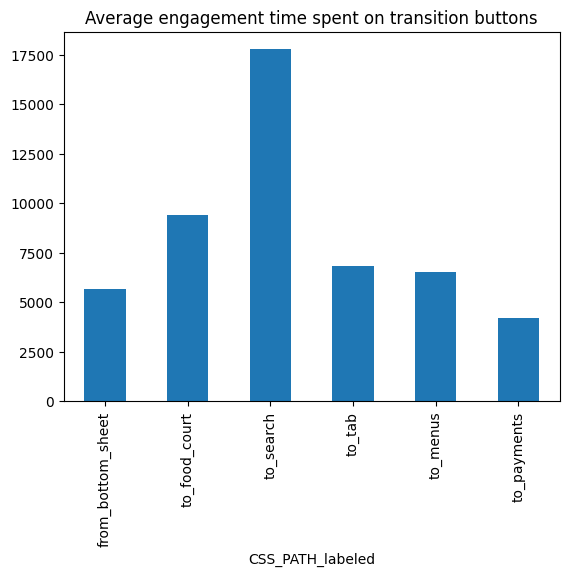

In [24]:
ax = df_transition_time.plot(kind = "bar",
                        title = "Average engagement time spent on transition buttons")
ax.set_xticklabels(labels)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


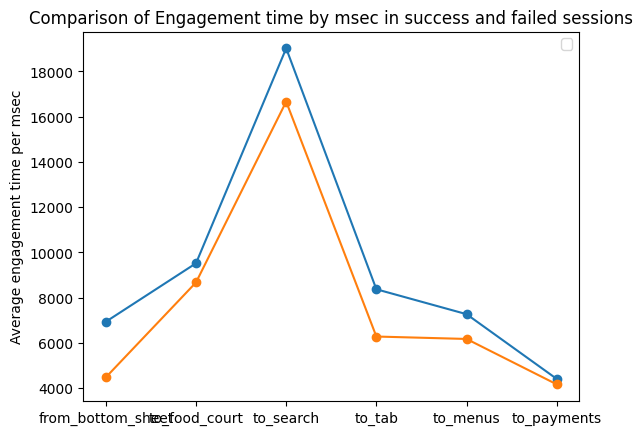

In [25]:
plt.plot(df_transition_time_failed, marker='o')

# Plotting the second set of values
plt.plot(df_transition_time_success, marker='o')

# Adding labels and title
plt.ylabel('Average engagement time per msec')
plt.title('Comparison of Engagement time by msec in success and failed sessions')
plt.xticks(df_transition_time_failed.index, labels)
plt.legend()

# Display the plot
plt.show()

In [26]:
df_diff_time = abs(df_transition_time_failed - df_transition_time_success)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


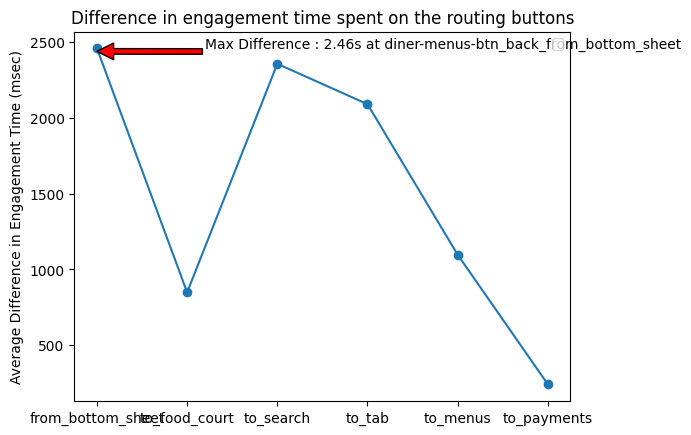

In [27]:
# Assuming df_diff_time is a DataFrame with your data
# Replace this with your actual data
# df_diff_time = ...

# Generate some sample data for illustration purposes
# Plot the data
fig, ax = plt.subplots()
line, = ax.plot(df_diff_time, marker="o")
ax.set_title("Difference in engagement time spent on the routing buttons")
plt.ylabel("Average Difference in Engagement Time (msec)")
ax.set_xticks(df_diff_time.index)
ax.set_xticklabels(labels)

# Find the index of the maximum y-value
max_index = df_diff_time.idxmax()
x_coord = df_diff_time.index.get_loc(max_index)
y_coord = df_diff_time.loc[max_index]

# Annotate the point with additional information
annotation = ax.annotate(f'Max Difference : {y_coord / 1000:.2f}s at {max_index}',
                         xy=(x_coord, y_coord - 20),xycoords='data',
                         xytext=(1.2, y_coord), 
                         arrowprops=dict(facecolor='red', linewidth=1),
                         )

# Add legend
ax.legend()

# Show the plot
plt.show()

From the difference graph, we can see that the transition from buttom sheet takes the longest time followed by the to_search button with the least difference coming from to_payments. 

# Recurring Users

In [28]:
customer_unique_user_counts = df.groupby('customerId')['user_pseudo_id'].nunique()

filtered_counts = customer_unique_user_counts[customer_unique_user_counts > 1]

recurring = filtered_counts.count()

print(recurring)

364


In [29]:
my_report = sv.analyze(df)

                                             |                                                                …

# Exploratory Data Analysis


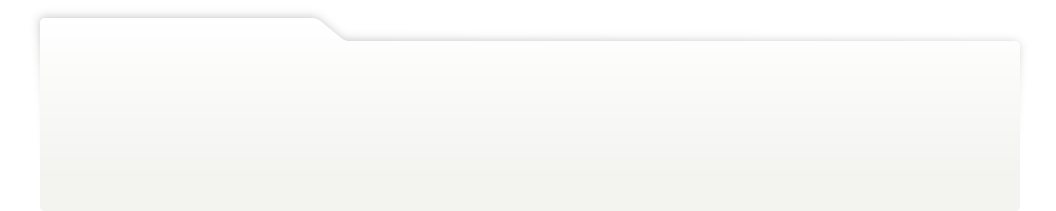
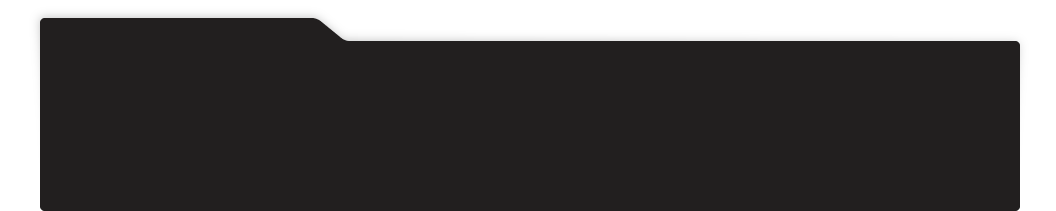
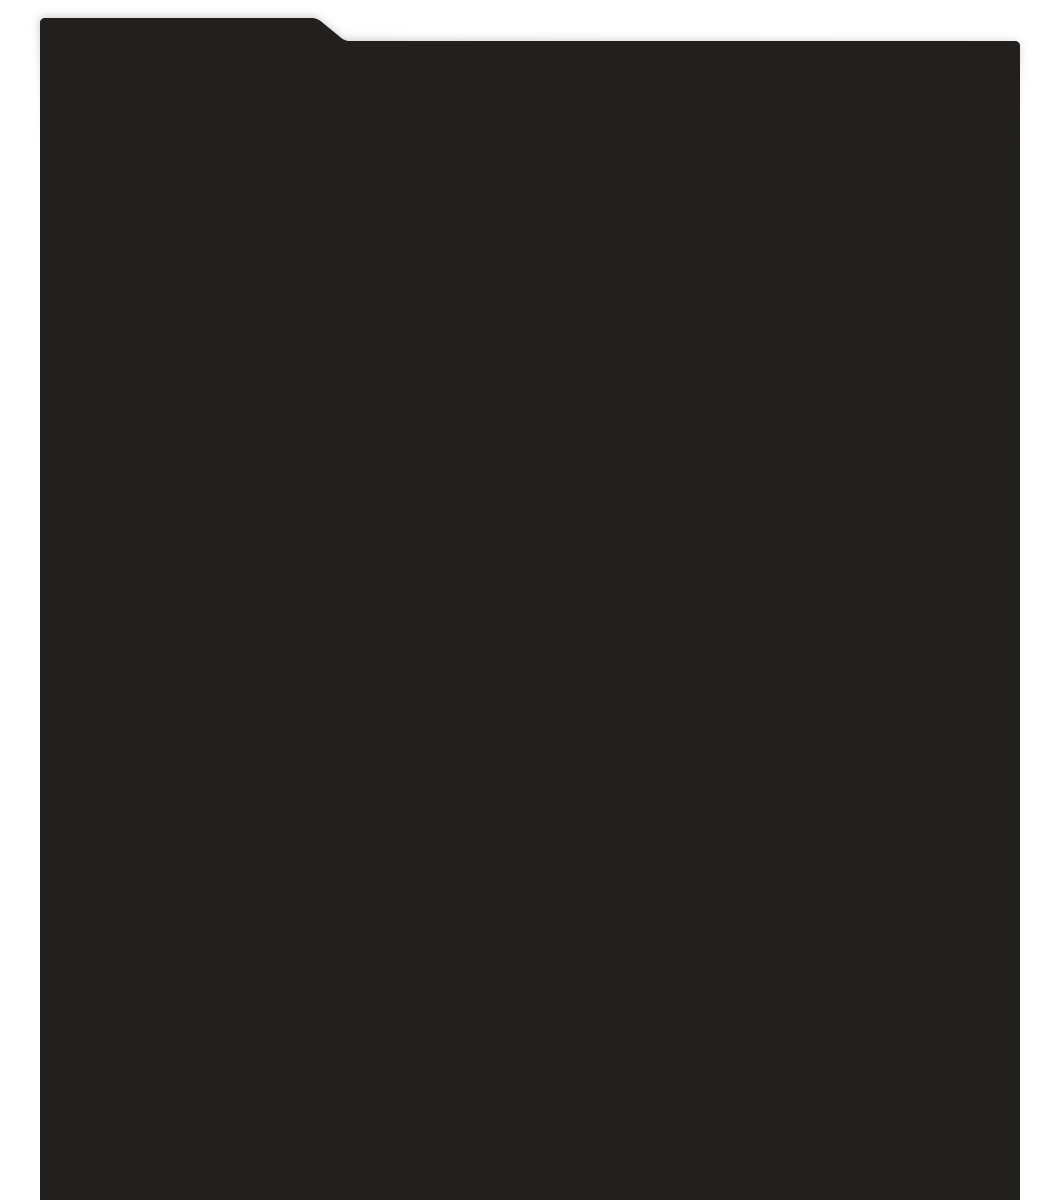
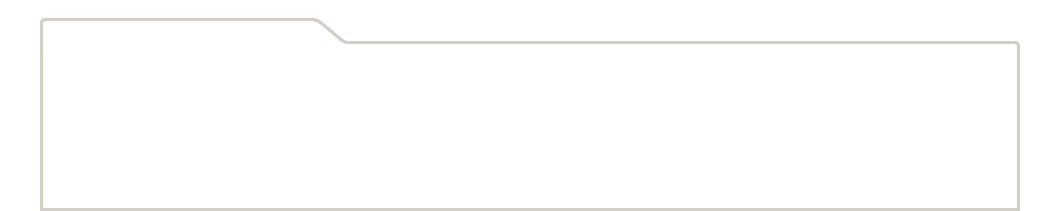
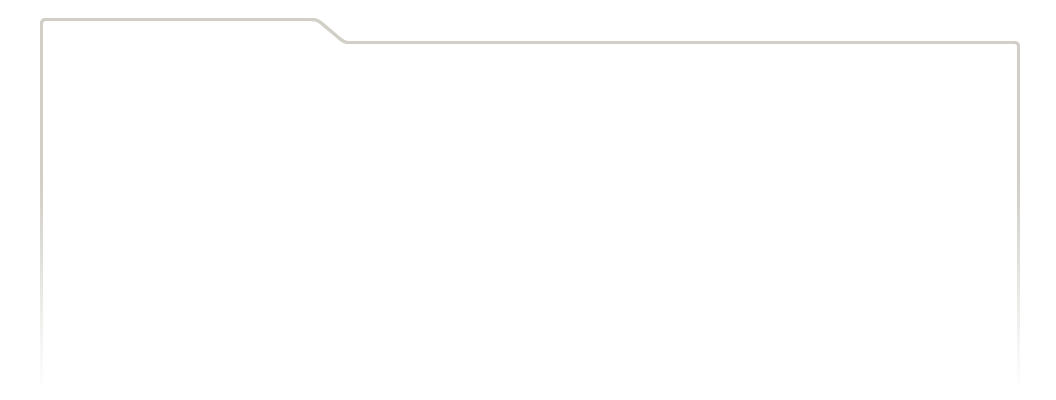
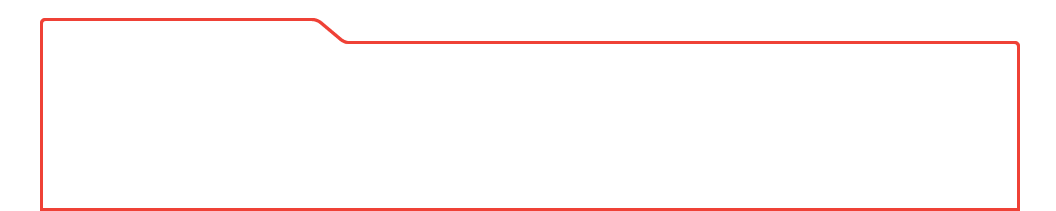
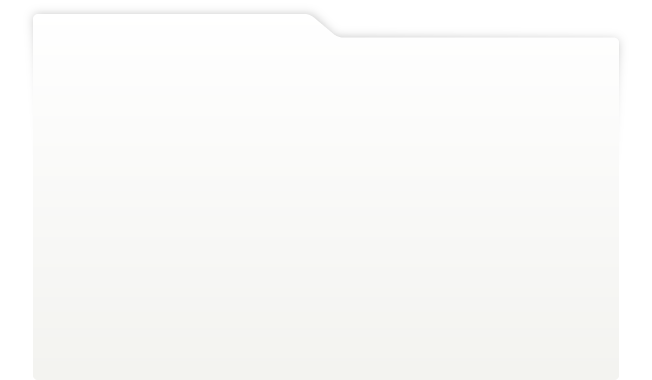
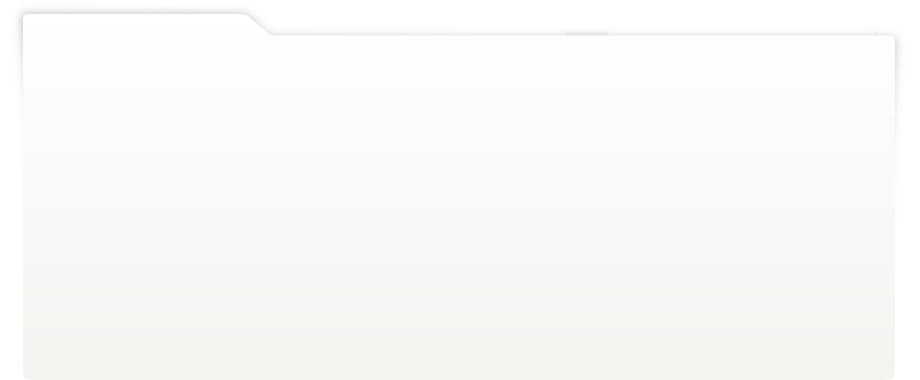
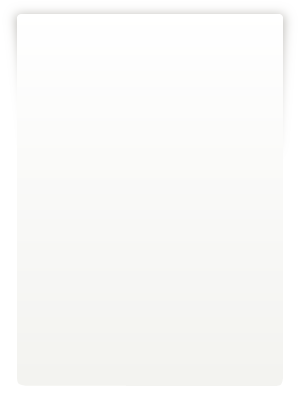
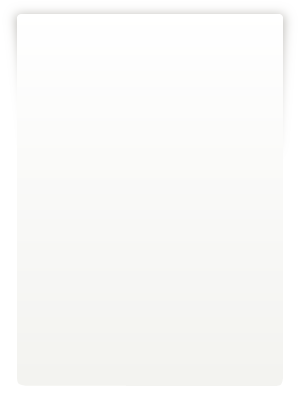
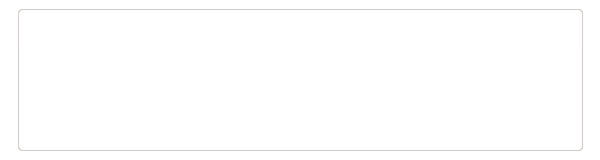
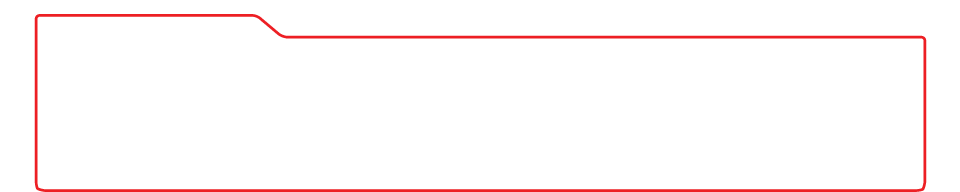
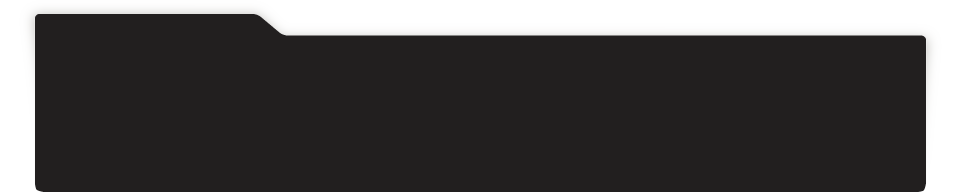
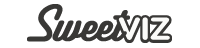
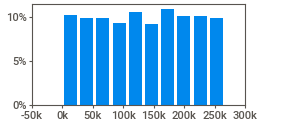
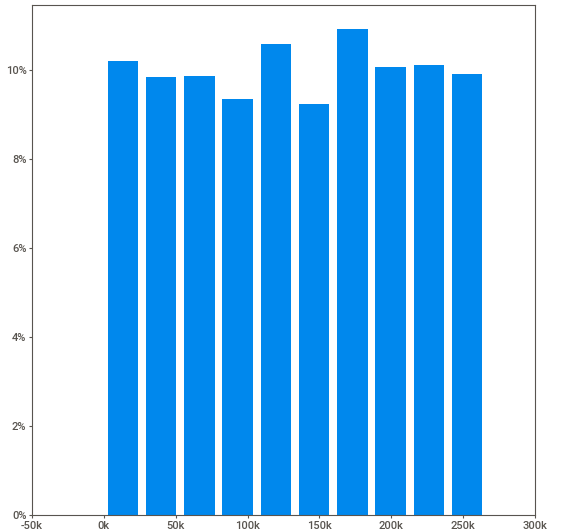
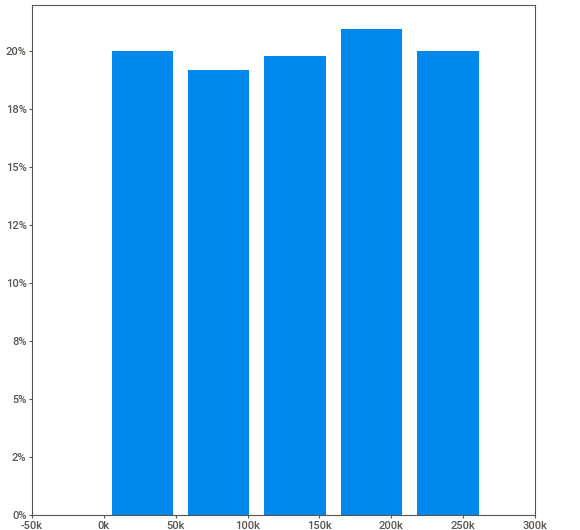
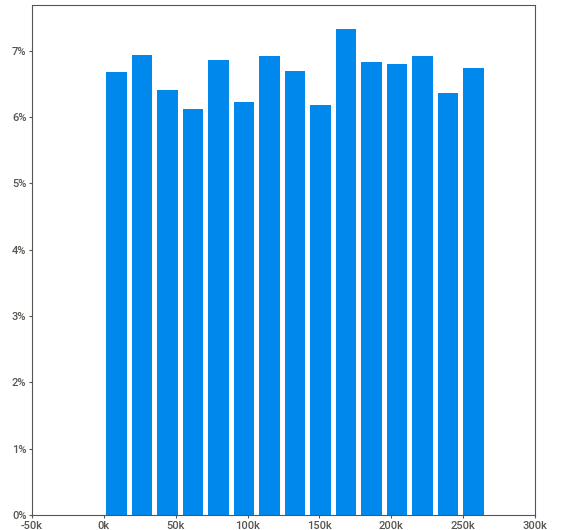
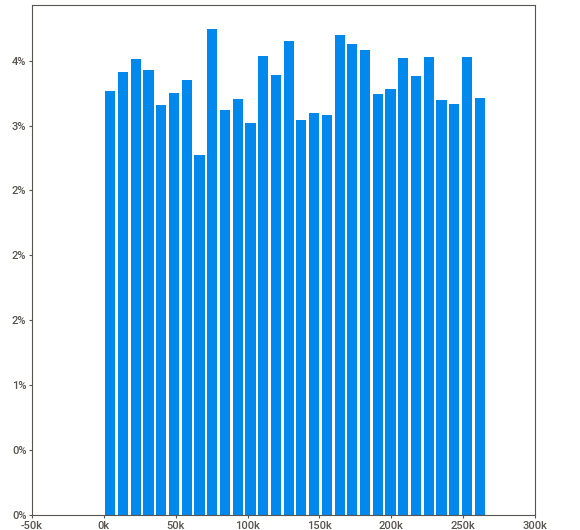
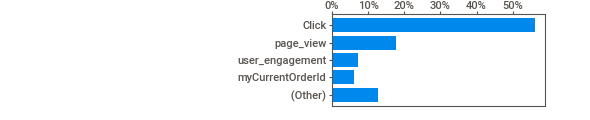
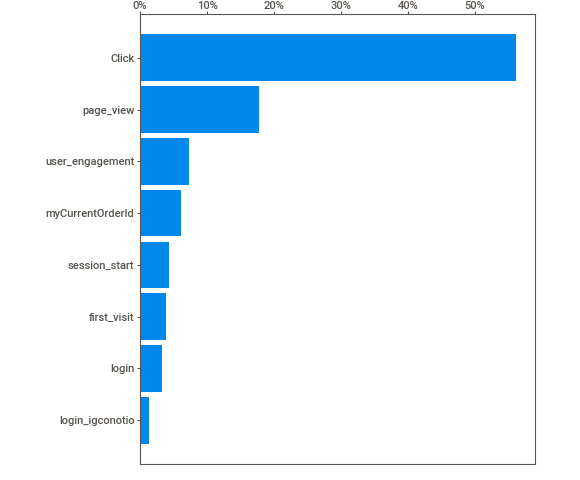
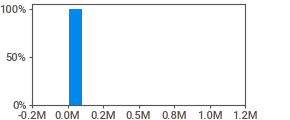
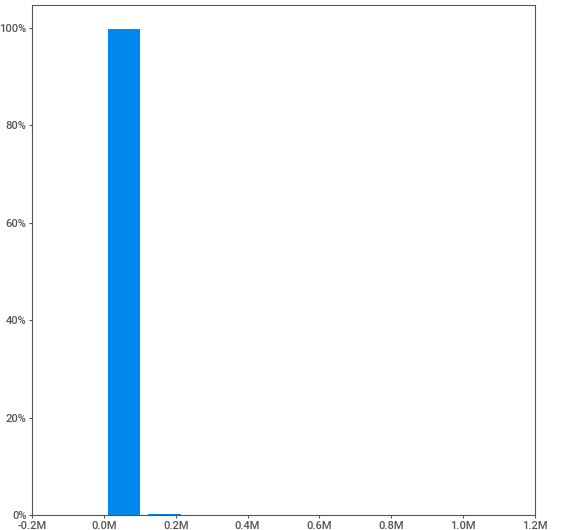
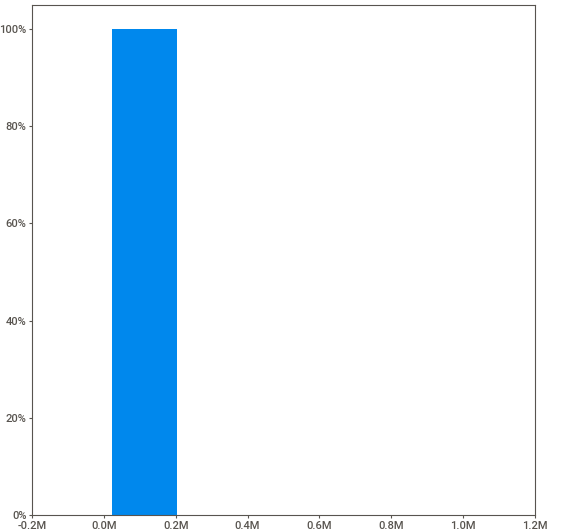
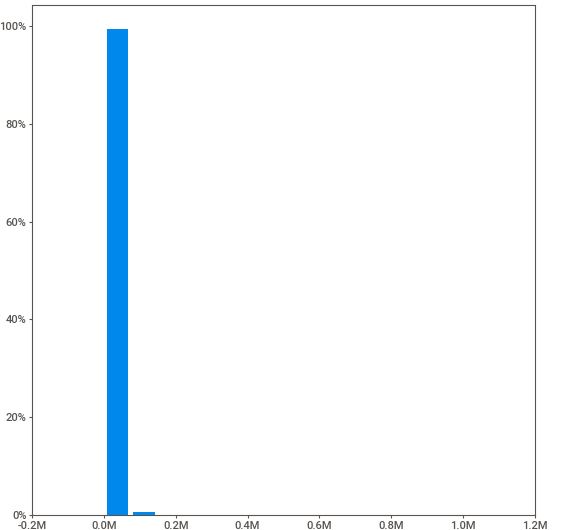
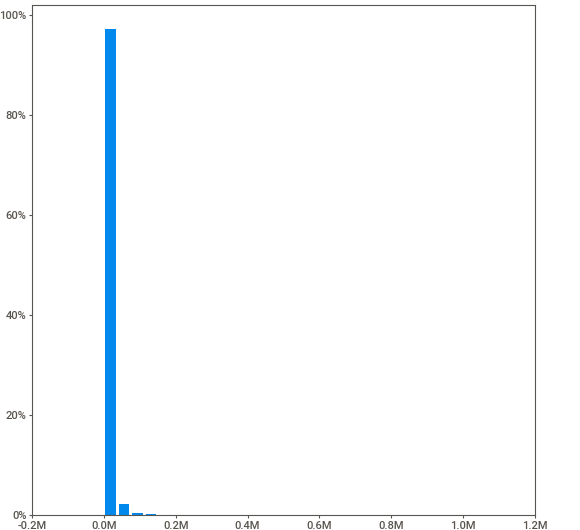
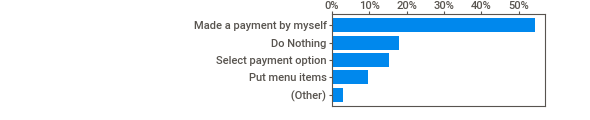
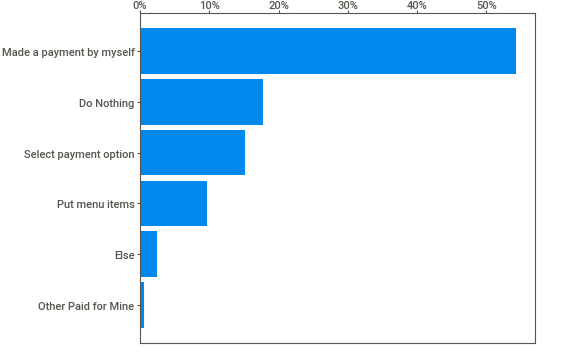
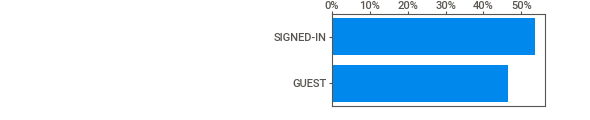
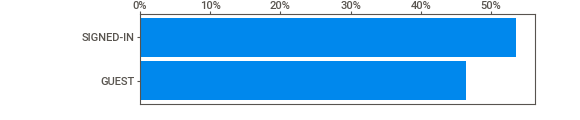
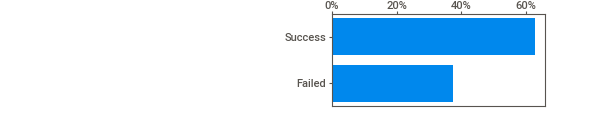
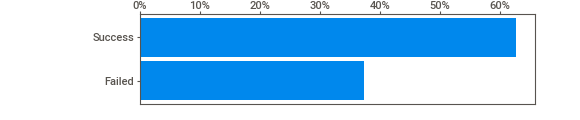
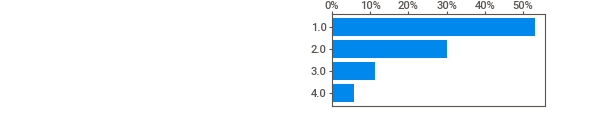
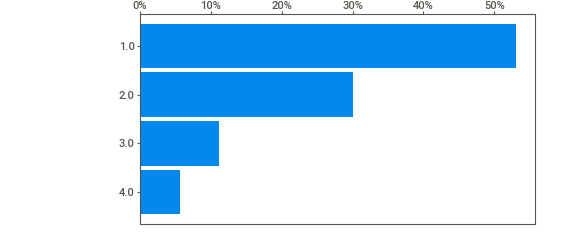
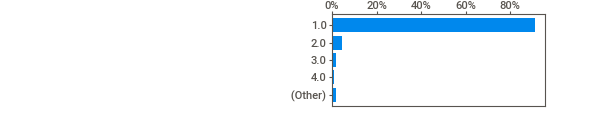
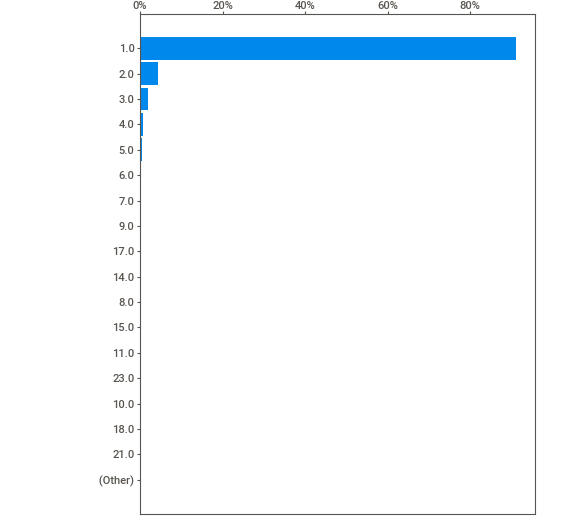
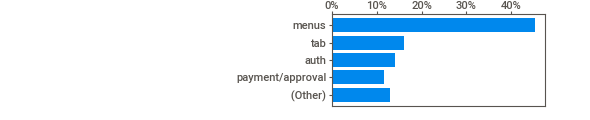
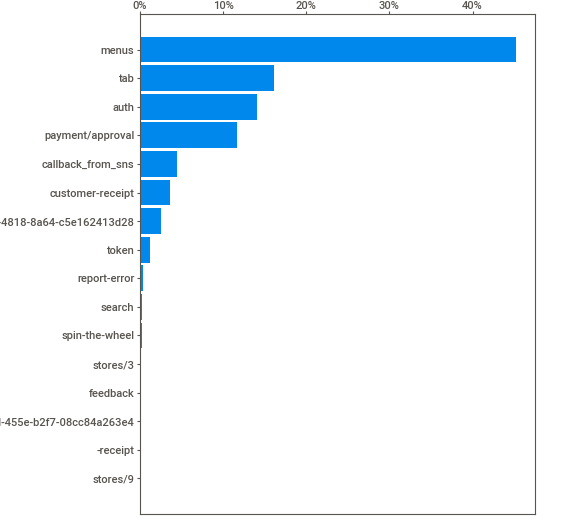
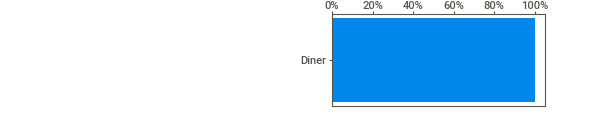
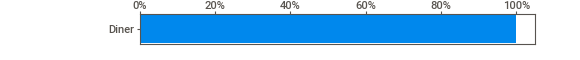
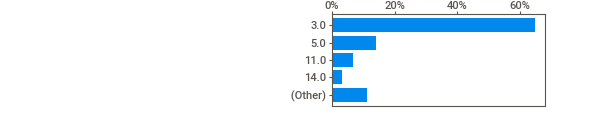
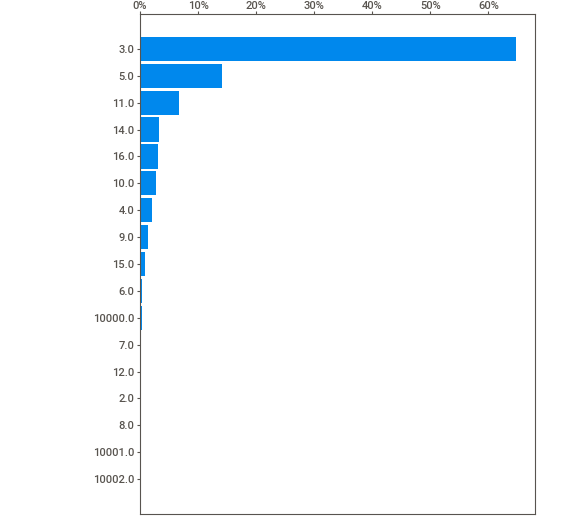
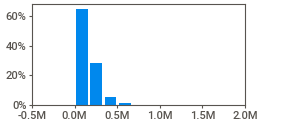
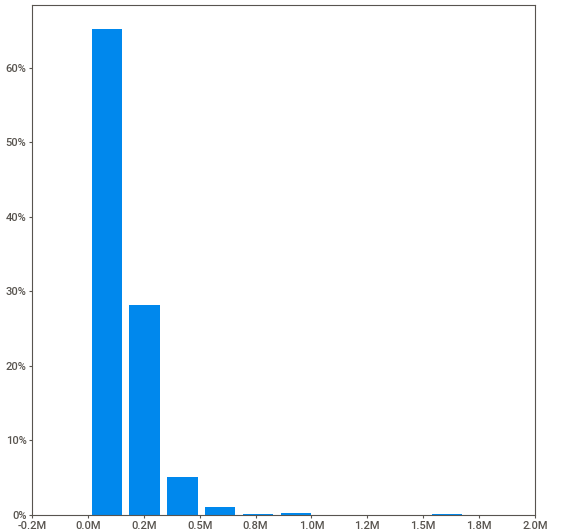
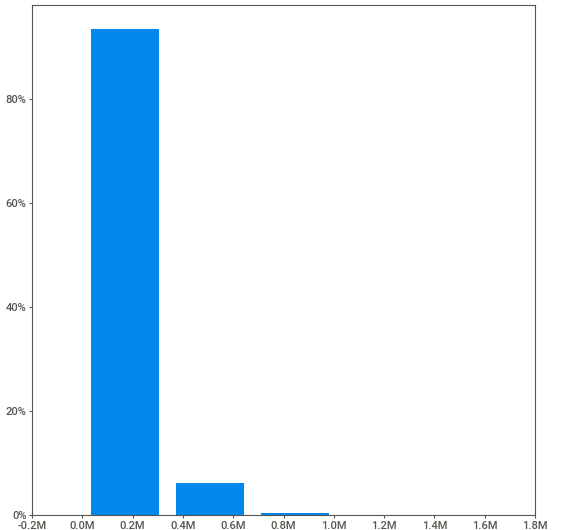
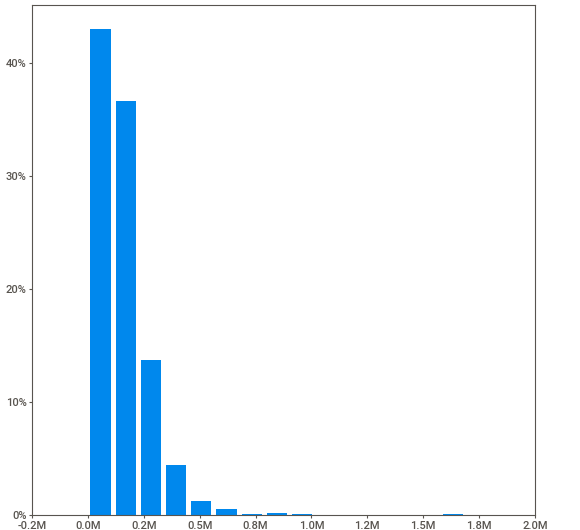
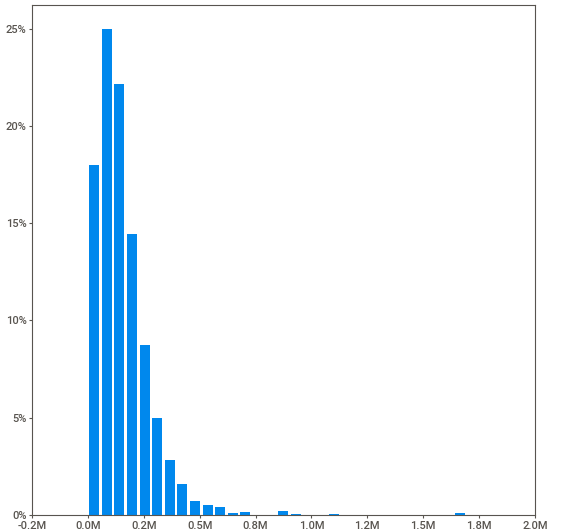
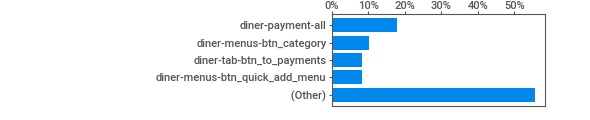
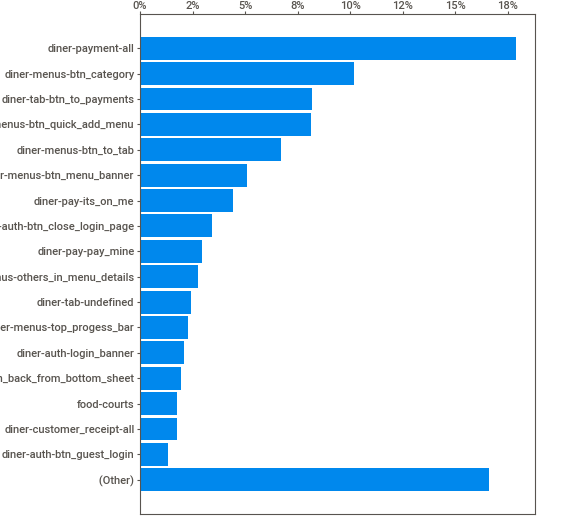
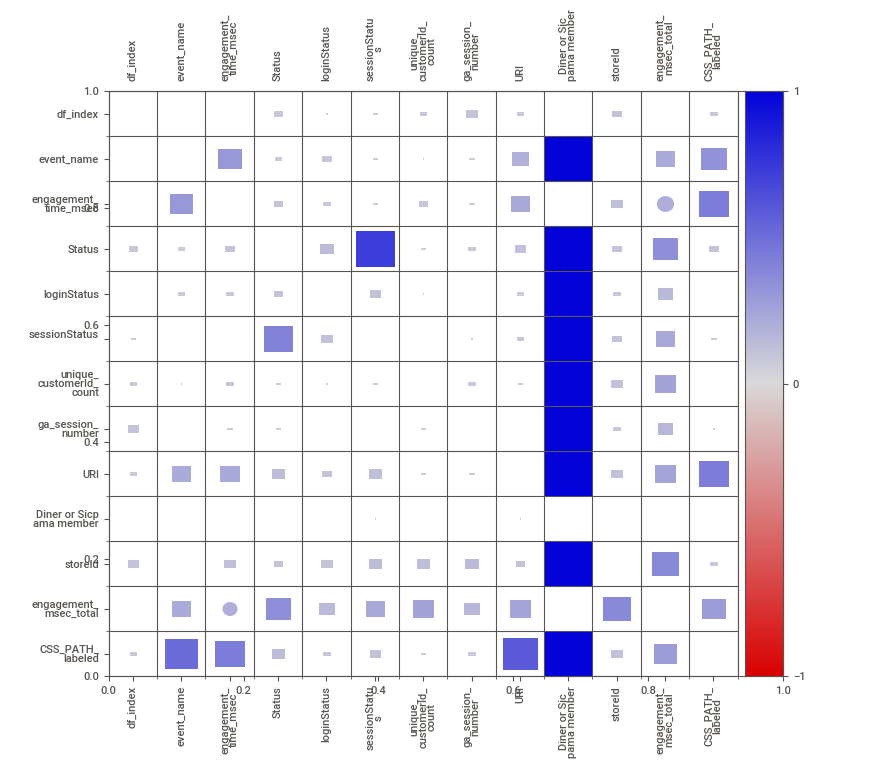
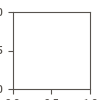

In [30]:
my_report.show_notebook()